In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import RandomizedSearchCV, ShuffleSplit
import seaborn as sns
import torch
import FashionMNIST.utils as fashionmnist_utils
from torchvision import transforms

import warnings
sns.set_style("ticks")

### Reload Best Attacker Data and Plot Graphs

In [2]:
def compile_report_fashion(path, lamb):
    report = torch.load(path)

    data_point = []
    iteration = []
    number_evals = []
    perturbation_norms = []
    predictions = []
    labels = []
    changed_images = []
    first_term_of_loss = []

    model = fashionmnist_utils.get_model(os.path.join('FashionMNIST', 'model', 'resnet.pt'), torch.device('cpu'))

    for i in range(len(report)):
        data_point.extend([i] * len(report[i]))
        original = report[i][0]["x"]
        labels.extend([report[i][0]["y"]] * len(report[i]))
        results = [report[i][j]["x"] + original for j in range(len(report[i]))]

        iteration.extend(range(len(report[i])))
        number_evals.extend(report[i][j]["evals"] for j in range(len(report[i])))
        perturbation_norms.extend([np.linalg.norm(original - results[j], 2) for j in range(len(report[i]))])
        
        # use the data and model to get the predicted label
        pred_classes = []
        loss = []
        for i, image in enumerate(results):
            image_3channels = transforms.Lambda(lambda x: torch.tensor(x).repeat(1, 3, 1, 1))(image)
            with torch.no_grad():
                output = model(image_3channels.type(torch.FloatTensor))
            pr = torch.nn.functional.softmax(output[0], dim=0).cpu().numpy()
            try:
                loss += [fashionmnist_utils.untargeted_zoo_loss([report[i][0]["y"]], pr)[0]]
            except:
                loss += [fashionmnist_utils.untargeted_zoo_loss([report[i][0]["y"]], pr)]
            pred_classes += [np.argmax(pr)]

        first_term_of_loss.extend(loss)
        predictions.extend(pred_classes)
        changed_images.extend(results)

    results_df = pd.DataFrame(
        {**{"data_point" : data_point,
         "iteration" : iteration,
         "num_function_evals": number_evals,
         "perturbation_norm": perturbation_norms,
         "predictions": predictions,
         "zoo_attack_loss": first_term_of_loss,
         "label" : labels,
         "optimizer": len(labels) * ["AdaZORO" if False else "ZORO"],
         "lambda" : len(labels) * [lamb],
         "dimensionality" : len(labels) * [784]
        },
        **{f'pixel_{i}': row for i, row in enumerate(np.vstack(changed_images).T)}}
    )
    results_df.to_csv('report_thingy.csv')
    return results_df

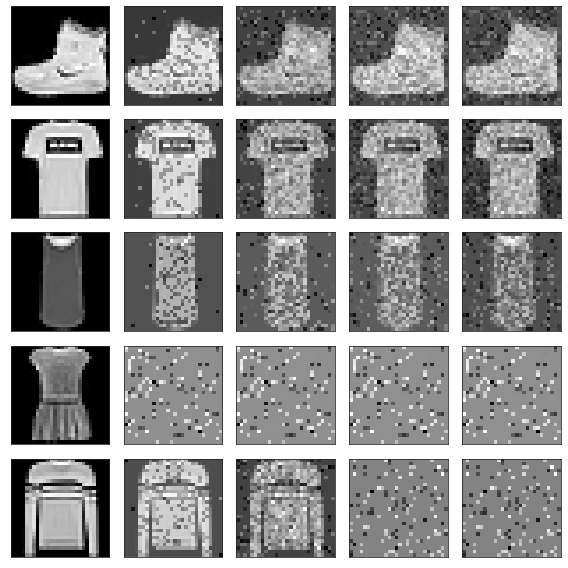

In [23]:
# make and plot adversarial images
report_lamb_01 = compile_report_fashion('ZORO_L_001_report.pt', 0.01)
pixel_cols = report_lamb_01.columns[report_lamb_01.columns.str.contains('pixel')]
imgs = [r.reshape((28, 28)) for r in report_lamb_01[pixel_cols].to_numpy()]
fig, axes = plt.subplots(5, 5, figsize=(8, 8))
ax = axes.ravel()

# plot
j = 0
for i, im in zip(range(len(imgs)), imgs):
    try:
        if (i % 14 in [0, 13] or (i % 14 - 1) % 4 == 0):
            img = (im + im.min()) / im.max()    
            ax[j].imshow(img, cmap='gray')
            ax[j].set_xticks([])
            ax[j].set_yticks([])
            j += 1
    except IndexError:
        break
plt.tight_layout()
plt.savefig('fashion_resulting_images.pdf')

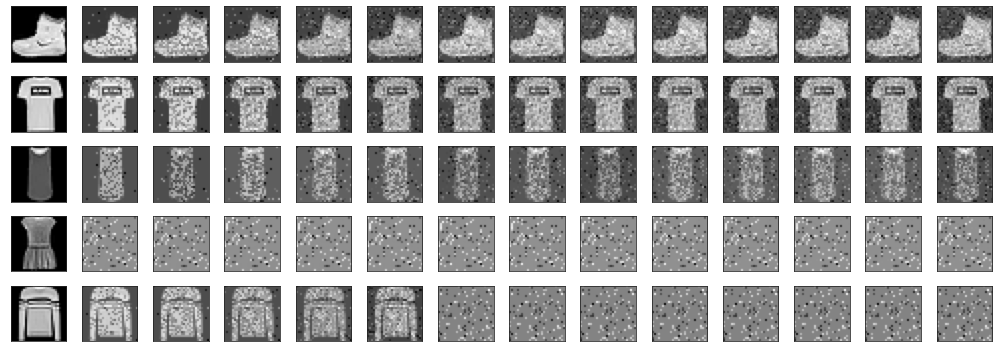

In [24]:
# make and plot adversarial images - pull panel
fig, axes = plt.subplots(5, 14, figsize=(14, 5))
ax = axes.ravel()
j = 0
for i, im in zip(range(len(imgs)), imgs):
    try:
        if (i % 14 in [0, 13] or (i % 14 - 1) % 1 == 0):
            img = (im + im.min()) / im.max()    
            ax[j].imshow(img, cmap='gray')
            ax[j].set_xticks([])
            ax[j].set_yticks([])
            j += 1
    except IndexError:
        break
plt.tight_layout()
plt.savefig('fashion_resulting_images_fullpanel.pdf')